# DistilBERT training and testing code


Notebook code is based on https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=BJR6t_gCQe_x
by Chris McCormick and Nick Ryan

We have adapted it for our use case, namely using a distillated version of BERT with weight decay

Original notebook was demonstrated in these videos:
- https://www.youtube.com/watch?v=x66kkDnbzi4&feature=youtu.be
- https://www.youtube.com/watch?v=Hnvb9b7a_Ps&feature=youtu.be

In [1]:
%run imports.py

Use GPU with code

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1070


Get a sample of the data

In [3]:
# Total number of instances to be split across train and test sets
total_sample = 350000

test_sample_size = 100000

In [4]:
raw_data = pd.read_csv("data/train-balanced-sarcasm.csv")[['label', 'comment']].dropna().sample(total_sample, random_state=1000)

In [5]:
# split data into 500000 and 100000 respectively
from sklearn.model_selection import train_test_split
df, df_test = train_test_split(raw_data, train_size=total_sample-test_sample_size, test_size=test_sample_size, stratify=raw_data['label'], random_state=1000)

In [6]:
#df_test = pd.read_csv("data/train-balanced-sarcasm.csv")[['label','comment']].dropna().sample(100000)
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

Number of test sentences: 100,000



In [7]:
# sample of 5 non sarcastic comments
df.loc[df.label == 0].sample(5)[['comment', 'label']]

,comment,label
743926,Dog walker!,0
453776,Computer Science #Luzon,0
139191,"It was just a perplexing move, if I had expect...",0
591162,One tab is where my tabs go to die.,0
38031,"In my opinion, ""Murder Was the Case"" is the be...",0


In [8]:
# sample of 5 sarcastic comments
df.loc[df.label == 1].sample(5)[['comment', 'label']]

,comment,label
929624,"ok, let's all just take your word for it.",1
760766,"No way, who would think of looking for the CM1...",1
995389,Hey buddy I've been on this Keesler vacation f...,1
955755,r/Christianity can stay .....,1
699669,Where can I Drink and Eat Hot Chicken?,1




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [9]:
# Get the lists of sentences and their labels.
def max_len_filter(x):
    if len(x) < 512:
        return x
    else:
        return np.nan

max_len_sentences = df.loc[df['comment'].str.len() < 512]

sentences = max_len_sentences.comment.values
labels = max_len_sentences.label.values

num_removed = len(df) - len(sentences)

print("Number of sentences < 512 tokens removed from {} sentences: {}".format(len(df), num_removed))

Number of sentences < 512 tokens removed from 250000 sentences: 62


### Tokenizer

In [10]:
from transformers import DistilBertTokenizer

# Load the DistilBERT tokenizer.
print('Loading DistilBERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading DistilBERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [11]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  I made this.
Tokenized:  ['i', 'made', 'this', '.']
Token IDs:  [1045, 2081, 2023, 1012]


In [12]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  I made this.
Token IDs: [101, 1045, 2081, 2023, 1012, 102]


Pad our tokens according to max length in the sample

In [13]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  192


In [14]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = max([len(sen) for sen in input_ids]) + 2

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 194 values...

Padding token: "[PAD]", ID: 0

Done.


The attention mask simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [15]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

Divide up our training set to use 90% for training and 10% for validation.

In [16]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=1000, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=1000, test_size=0.1)

In [17]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).type(torch.LongTensor)
validation_inputs = torch.tensor(validation_inputs).type(torch.LongTensor)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


Now that our input data is properly formatted, it's time to fine tune the DistilBERT model. 

In [19]:
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_hidden_states=True
)

# Tell pytorch to run this model on the 
model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [20]:
# implement weight decay for bias parameters
no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [
    {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0}
    ]
    
optimizer = AdamW(optimizer_grouped_parameters, 
                  lr=2e-5, 
                  eps=1e-8)

In [21]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                  
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Define a helper function for calculating accuracy.

In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## Let's start training!

we calculate sentence embeddings by averaging for each input, the hidden layers of all tokens.

http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#33-creating-word-and-sentence-vectors-from-hidden-states

In [24]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 1000

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        
        # get the layer before the final layer as the embeddings
        token_vecs = outputs[2][-1]
        sentence_embedding = torch.mean(token_vecs, dim=1)
        
        np.save("embedded_data/batch_{}_sen_embeddings.npy".format(step), sentence_embedding.detach().cpu().numpy())
        
        # save the labels
        np.save("embedded_labels/batch_{}_sen_labels.npy".format(step), b_labels.detach().cpu().numpy())

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  28,118.    Elapsed: 0:00:07.
  Batch    80  of  28,118.    Elapsed: 0:00:14.
  Batch   120  of  28,118.    Elapsed: 0:00:21.
  Batch   160  of  28,118.    Elapsed: 0:00:28.
  Batch   200  of  28,118.    Elapsed: 0:00:35.
  Batch   240  of  28,118.    Elapsed: 0:00:42.
  Batch   280  of  28,118.    Elapsed: 0:00:49.
  Batch   320  of  28,118.    Elapsed: 0:00:55.
  Batch   360  of  28,118.    Elapsed: 0:01:02.
  Batch   400  of  28,118.    Elapsed: 0:01:09.
  Batch   440  of  28,118.    Elapsed: 0:01:16.
  Batch   480  of  28,118.    Elapsed: 0:01:23.
  Batch   520  of  28,118.    Elapsed: 0:01:30.
  Batch   560  of  28,118.    Elapsed: 0:01:37.
  Batch   600  of  28,118.    Elapsed: 0:01:44.
  Batch   640  of  28,118.    Elapsed: 0:01:51.
  Batch   680  of  28,118.    Elapsed: 0:01:57.
  Batch   720  of  28,118.    Elapsed: 0:02:04.
  Batch   760  of  28,118.    Elapsed: 0:02:11.
  Batch   800  of  28,118.    Elapsed: 0:02:1

Let's take a look at our training loss over all batches:

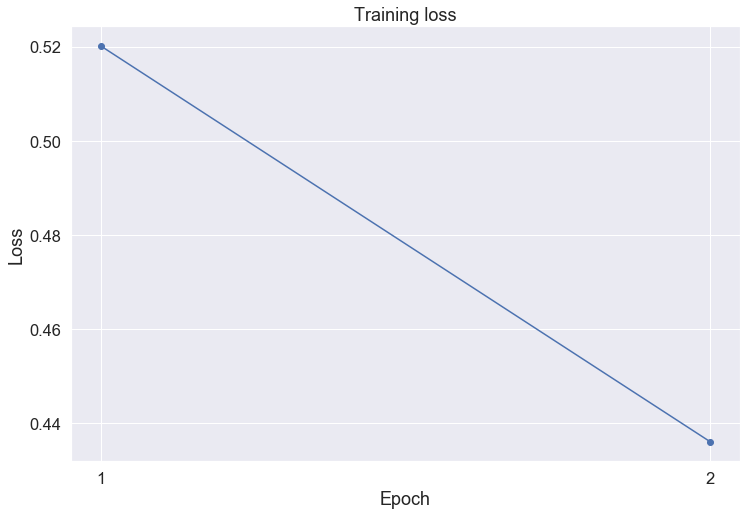

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
ax.set_xticks(np.arange(0,2))
ax.set_xticklabels(np.arange(1,3))
plt.show()

fig.savefig("plots/distilbert_400k_trainingloss_2epochs.png", dpi=250, bbox_inches='tight')


Let's see the performance on test data

In [28]:
test_sentences = df_test.comment.values
test_labels = df_test.label.values

In [29]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in test_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids).type(torch.LongTensor)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [30]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 100,000 test sentences...
    DONE.


In [31]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.label.sum(), len(df_test.label), (df_test.label.sum() / len(df_test.label) * 100.0)))

Positive samples: 50024 of 100000 (50.02%)


In [32]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                

    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 


In [33]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.529


In [34]:
from sklearn.metrics import classification_report, accuracy_score

report = classification_report(flat_true_labels, flat_predictions, target_names=['ns', 's'], output_dict=True)
acc = accuracy_score(flat_true_labels, flat_predictions)
print(report)
print(acc)

report_df = pd.DataFrame(report).transpose()

{'ns': {'precision': 0.7571756825174281, 'recall': 0.7780534656635185, 'f1-score': 0.7674726142307313, 'support': 49976}, 's': {'precision': 0.7719853636475764, 'recall': 0.7507196545658084, 'f1-score': 0.7612040133779264, 'support': 50024}, 'accuracy': 0.76438, 'macro avg': {'precision': 0.7645805230825022, 'recall': 0.7643865601146634, 'f1-score': 0.7643383138043289, 'support': 100000}, 'weighted avg': {'precision': 0.7645840774059736, 'recall': 0.76438, 'f1-score': 0.7643368093401242, 'support': 100000}}
0.76438


In [35]:
results = pd.DataFrame({'Score':[mcc, acc]}, index=['MCC', 'Accuracy'])

In [36]:
report_df.to_csv("results/distilbert_400k_2epoch_clf_report")
results.to_csv("results/distilbert_400k_2epoch_results")

hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.)

## Code to save and load models

In [38]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'saved_models/DistilBERT_base_400ktrained_2epochs'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to saved_models/DistilBERT_base_400ktrained_2epochs


('saved_models/DistilBERT_base_400ktrained_2epochs\\vocab.txt',
 'saved_models/DistilBERT_base_400ktrained_2epochs\\special_tokens_map.json',
 'saved_models/DistilBERT_base_400ktrained_2epochs\\added_tokens.json')

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)